# Aplicação: Seleção de Atributos em Imagens Digitais via Meta-heurística


Elaborado por: **Davi Augusto Neves Leite**, **Giovani Candido** e **Luis Henrique Morelli**.

Este notebook apresenta um exemplo de aplicação de meta-heurística para a seleção de características de imagens visando a classificação de padrões. Para tal, selecionou-se a base **Fashion-MNIST**. Em seguida, realizou-se um pré-processamento para separar as classes de interesse e obter as características das imagens. Tais características foram extraídas por meio de **descritores de textura de Haralick**. Além disso, os **pixels das imagens** foram unidos às características para gerar vetores de atributos de maior dimensão. Em relação aos algoritmos, optou-se pelo modelo **Classificador KNN**, que foi avaliado em dois cenários: sem e com seleção de atributos. Para a seleção, selecionou-se a meta-heurística de otimização **Binary PSO (BPSO)** e seguiu-se o método de seleção **wrapper**, baseado na avaliação do desempenho do modelo.

</br></br>

---
</br></br>

## Instalação do Módulo de Meta-Heurísticas


O ambiente do **Google Colab** possui inúmeros módulos já instalados por padrão. No entanto, um dos módulos utilizados não está incluso nessa lista padrão, que é o caso do **Opytimizer**. Trata-se de uma biblioteca que contém a implementação de várias meta-heurísticas.


O comando abaixo realiza a instalação dessa biblioteca.

In [ ]:
%pip install opytimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


</br></br>

---
</br></br>

## Importação da Base Fashion-MNIST


Com o Opytimizer já instalado, passa-se a trabalhar com a base de dados **Fashion-MNIST**. Esse conjunto contém **70.000 imagens** com **256 níveis de cinza** e dimensão **28x28 (784 pixels)**. Desse total, existem **7.000 imagens** para cada uma das **10 classes de roupas**.

Para importar as imagens, utiliza-se o módulo **scikit-learn**, capaz de carregar diversas bases de dados através do portal **OpenML**.

In [ ]:
from sklearn.datasets import fetch_openml

Em seguida, carrega-se as imagens e suas respectivas classes.

In [ ]:
# Carrega as imagens e seus rótulos
images, targets = fetch_openml('Fashion-MNIST', return_X_y=True, as_frame=True, parser='auto')

Por fim, converte-se as imagens e as classes para arrays.

In [ ]:
# Converte os itens para array
images = images.to_numpy()
targets = targets.to_numpy().astype(int)

</br></br>

---
</br></br>

## Pré-processamento dos Dados


Com as imagens carregadas, inicia-se a fase de pré-processamento.

#### Separação das Classes de Interesse

O comando abaixo importa o módulo **NumPy** para a manipulação de arrays.

In [ ]:
import numpy as np

Separa-se as classes **0 (camiseta)**, **4 (casaco)** e **6 (camisa)** para constituir um problema de classificação com três padrões.

In [ ]:
# Define as classes de interesse e
# atribui os novos rótulos a elas
labels_map = {0: 0, 4: 1, 6: 2}

selected_images = []
selected_targets = []

# Percorre as imagens
for idx, label in enumerate(targets):
    
    # Se o rótulo da imaten atual estiver 
    # dentre as classes de interesse
    if label in labels_map.keys():
        # Salva a imagem
        selected_images.append(images[idx])

        # Salva seu novo rótulo
        selected_targets.append(labels_map[targets[idx]])

# Converte para array
selected_images = np.array(selected_images)
selected_targets = np.array(selected_targets)

Cria-se um dicionário com os rótulos das classes.

In [ ]:
labels_descr = {0: 'camiseta', 1: 'casaco', 2: 'camisa'}

#### Exibição das Classes

Para ilustrar as imagens das classes separadas, esta seção realiza apresenta uma amostra de cada classe.

De início, importa-se o **matplotlib** para a exibição das imagens.

In [ ]:
import matplotlib.pyplot as plt

Cria-se uma figura com uma imagem de cada classe.

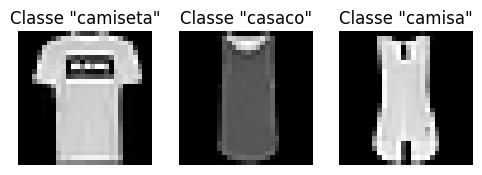

In [ ]:
plt.figure(figsize=(10, 8))

n_rows = 1
n_cols = 5

# Exibe uma amostra de cada classe
for label, image_idx in enumerate(labels_descr.keys()):
    plt.subplot(n_rows, n_cols, label + 1)
    plt.title(f'Classe "{labels_descr[label]}"')
    plt.imshow(selected_images[image_idx].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

#### Extração de Características

Agora, entra-se na fase de extração de características.

Define-se uma função que retorna o vetor de características de uma imagem, composto por descritores de Haralick e pixels da imagem.

In [ ]:
from skimage.feature import graycomatrix, graycoprops

from tqdm.notebook import tqdm

def extract_features(image, distances, angles, props):
    reshaped_img = image.reshape(28, 28).astype(np.uint8)

    glcm = graycomatrix(reshaped_img, distances, angles)
    
    haralick_descriptors = []

    for p in props:
        haralick_descriptors.append(graycoprops(glcm, p))
    
    # Converte os descritores para um array 1d
    haralick_descriptors = np.array(haralick_descriptors).flatten()

    # Adiciona os pixels da imagem como atributos,
    # juntamente com os descritores de Haralick
    features = np.hstack((image, haralick_descriptors))

    return features

Executa-se a extração de características das imagens. Para o cálculo da matriz de co-ocorrência, foi considerada uma **distância de 5 pixels**, com uma análise dos ângulos **0, 45, 90 e 135** graus. Em relação aos descritores, foram consideradas seis propriedades de textura: **contraste**, **dissimilaridade**, **homogeneidade**, **energia**, **correlação** e **Segundo Momento Angular (ASM)**. 

In [ ]:
distances = [5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

props = [
    'contrast', 
    'dissimilarity', 
    'homogeneity', 
    'energy', 
    'correlation', 
    'ASM']

features = []

for image in tqdm(selected_images):
    features.append(extract_features(image, distances, angles, props))

  0%|          | 0/21000 [00:00<?, ?it/s]

Exibe-se o total de atributos obtidos para cada imagem.

In [ ]:
features[0].size

808

Determina-se os vetores X e y do problema de classificação com base nos atributos e nas classes.

In [ ]:
# Converte os itens para array
X = np.array(features)
y = np.array(selected_targets)

</br></br>

---
</br></br>

## Implementação do Classificador KNN

Nesta seção, implementa-se o **classificador KNN**. Esse modelo toma as classes das **k** amostras de treinamento mais próximas a uma amostra de teste como base para realizar a classificação. Em síntese, a classe mais frequente é assumida como classe da observação de interesse.

O bloco abaixo implementa o modelo a partir do módulo PyTorch.

In [ ]:
import torch

class KNNClassifier:
    
    def __init__(self, k=5, p=2, device='cuda'):
        # Inicializa os atributos da classe
        self.k = k
        self.p = p
        self.device = device
    
    def fit(self, X, y):
        # Salva as amostras e suas classes como tensores
        self.X_train = torch.from_numpy(X).float().to(self.device)
        self.y_train = torch.from_numpy(y).to(self.device)
    
    def predict(self, X):
        # Converte as amostras de teste em tensores
        X_test = torch.from_numpy(X).float().to(self.device)

        # Calcula a distância entre as amostras de teste e as de treinamento
        dists = torch.cdist(X_test, self.X_train, p=self.p)

        # Obtém o índice das k amostras de treinamento mais próximas a cada amostra de teste
        _, indices = torch.topk(dists, k=self.k, dim=-1, largest=False)

        # Obtém a classe dessas amostras de treinamento mais próximas
        k_nearest_labels = self.y_train[indices]

        # Determina as classes das amostras de teste com base nas k amostras de treinamento
        predictions = torch.mode(k_nearest_labels, dim=-1)[0]

        # Retorna as predições
        return predictions.cpu().numpy()

</br></br>

---
</br></br>

## Classificação de Padrões

Neste momento, inicia-se a fase de classificação de padrões sem a seleção de atributos.

### Divisão dos Dados

Primeiramente, realiza-se a divisão dos dados em subconjuntos de treinamento e teste.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Avaliação do Modelo

Na sequência, salva-se as amostras de treinamento e classifica-se as observações de teste.

In [ ]:
knn = KNNClassifier()

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

Por fim, avalia-se o modelo com base em métricas de classificação.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=labels_descr.values()))

              precision    recall  f1-score   support

    camiseta       0.78      0.86      0.82      1381
      casaco       0.81      0.83      0.82      1410
      camisa       0.69      0.60      0.64      1409

    accuracy                           0.77      4200
   macro avg       0.76      0.77      0.76      4200
weighted avg       0.76      0.77      0.76      4200



</br></br>

---
</br></br>

## Classificação de Padrões com Seleção de Atributos

Neste momento, inicia-se a fase de classificação de padrões considerando a seleção de atributos para manter somente os mais relevantes.

### Divisão dos Dados

Separa-se parte do subconjunto de treinamento para a validação.

In [ ]:
# Separa entre conjunto de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Seleção de Atributos

Em primeiro lugar, define-se a função objetivo (ou custo) do problema. Como o método **wrapper** foi escolhido, essa função avalia a performance do modelo na classificação de amostras de validação com os atributos selecionados por um agente da meta-heurística.

In [ ]:
from sklearn.metrics import accuracy_score

def fitness_function(features):
    selected_features = features.reshape(-1).astype(int)

    selected_X_train = X_train[:, selected_features]
    selected_X_val = X_val[:, selected_features]

    knn = KNNClassifier()

    knn.fit(selected_X_train, y_train)

    y_pred = knn.predict(selected_X_val)

    return 1 - accuracy_score(y_val, y_pred)

Em seguida, executa-se a meta-heurística BPSO para a seleção de características.

In [ ]:
from opytimizer import Opytimizer
from opytimizer.core import Function
from opytimizer.optimizers.boolean import BPSO
from opytimizer.spaces import BooleanSpace

# Define uma seed para replicação dos resultados
np.random.seed(13)

# Define os parâmetros da meta-heurística
space = BooleanSpace(n_agents=20, n_variables=X_train.shape[1])
optimizer = BPSO()
function = Function(fitness_function)

# Instância a meta-heurística
opt = Opytimizer(space, optimizer, function)
                                                                                                                                                                                                                                                                                                                                                        
# Executa a seleção de atributos
opt.start(n_iterations=150)

2023-06-06 23:56:00,864 - opytimizer.spaces.boolean — INFO — Overriding class: Space -> BooleanSpace.
2023-06-06 23:56:01,052 - opytimizer.core.space — DEBUG — Agents: 20 | Size: (808, 1) | Lower Bound: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|##########| 150/150 [06:29<00:00,  2.60s/it, fitness=0.658]

2023-06-07 00:02:33,211 - opytimizer.opytimizer — INFO — Optimization task ended.
2023-06-07 00:02:33,213 - opytimizer.opytimizer — INFO — It took 392.11914014816284 seconds.


Exibe-se a melhor solução obtida pela meta-heurística.

In [ ]:
best_features = opt.history.best_agent[0][0]
best_features = np.array(best_features).reshape(-1)
best_features

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True, False, False, False,  True, False,  True, False, False,
       False, False,  True, False, False,  True, False, False,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True, False, False,  True,  True, False, False,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
        True,  True, False, False,  True, False, False, False,  True,
        True,  True,  True, False, False,  True, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False,  True,  True,  True, False, False,  True,
        True, False,

Mostra-se o número de atributos selecionados.

In [ ]:
np.sum(best_features)

387

### Avaliação do Modelo

Separa-se somente os atributos selecionados.

In [ ]:
selected_X_train = X_train[:, best_features]
selected_X_test = X_test[:, best_features]

Na sequência, treina-se e classifica-se as amostras de teste.

In [ ]:
knn = KNNClassifier()

knn.fit(selected_X_train, y_train)

y_pred = knn.predict(selected_X_test)

Por fim, avalia-se o desempenho do modelo.

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels_descr.values()))

              precision    recall  f1-score   support

    camiseta       0.79      0.87      0.83      1381
      casaco       0.81      0.85      0.83      1410
      camisa       0.71      0.61      0.66      1409

    accuracy                           0.78      4200
   macro avg       0.77      0.78      0.77      4200
weighted avg       0.77      0.78      0.77      4200

